In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error


from collections import Counter
import re
import string
import tqdm
spacy.load('en_core_web_sm')

In [2]:
EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
NODES = 1000

In [3]:
df = pd.read_csv("../data/OnlineNewsPopularity_extended.csv")
print("calculating mean/median")
mean =  df["shares"].mean()
median = df["shares"].median()
print("mean: ", mean)
print("median: ", median)
[print(len(df))]

calculating mean/median
mean:  3395.3801836343455
median:  1400.0
39644


[None]

In [4]:
df.loc[df['shares'] < median, 'shares'] = 0
df.loc[df['shares'] >= median, 'shares'] = 1
df = df.iloc[:, 2:]

In [5]:
df['content'] = df['content'].fillna('')
df['content_length'] = df['content'].apply(lambda x: len(x.split()))

In [6]:
df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,title,content,label_by_mean,label_by_median,content_length
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.500000,-0.187500,0.000000,0.187500,0,Amazons Streaming Video Library Now a Little E...,Having trouble finding something to watch on A...,1,1,210
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,0,APs Twitter to Begin Displaying Sponsored Tweets,The Associated Press is the latest news organi...,1,1,250
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,1,Apples App Store Passes 40 Billion Downloads,It looks like 2012 was a pretty good year for ...,1,0,197
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,0,This Astronaut Is Rooting for Notre Dame Tonight,When it comes to college football NASA astrona...,1,1,478
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.454545,0.136364,0.045455,0.136364,0,New UVerse Apps Simplify Sharing Photos and Vi...,LAS VEGAS — Sharing photos and videos on your ...,1,1,289


In [7]:
# mean content length

np.mean(df['content_length'])

404.07882655635154

In [8]:
#tokenization
tok = spacy.load('en_core_web_sm')
def tokenize(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [9]:
#count number of occurences of each word
counts = Counter()
for index, row in df.iterrows():
    counts.update(tokenize(row['content']))

In [10]:
#deleting infrequnet words
print("num_words before:", len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 202157
num_words after: 102822


In [11]:
# creating vocab
vocab2index = {"":0, "UNK":1}
words = ["","UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [12]:
def encode_sentence(text, vocab2index, N=450):
    tokenized = tokenize(text)
    encoded = np.zeros(N,dtype=int)
    enc1 = np.array([vocab2index.get(word,vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [13]:
df['encoded'] = df['content'].apply(lambda x: np.array(encode_sentence(x,vocab2index)))
df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,title,content,label_by_mean,label_by_median,content_length,encoded
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,-0.187500,0.000000,0.187500,0,Amazons Streaming Video Library Now a Little E...,Having trouble finding something to watch on A...,1,1,210,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.000000,0.500000,0.000000,0,APs Twitter to Begin Displaying Sponsored Tweets,The Associated Press is the latest news organi...,1,1,250,"[[12, 145, 146, 98, 12, 99, 147, 85, 6, 148, 9..."
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.000000,0.500000,0.000000,1,Apples App Store Passes 40 Billion Downloads,It looks like 2012 was a pretty good year for ...,1,0,197,"[[81, 263, 264, 265, 139, 100, 78, 237, 140, 6..."
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.000000,0.500000,0.000000,0,This Astronaut Is Rooting for Notre Dame Tonight,When it comes to college football NASA astrona...,1,1,478,"[[336, 81, 337, 6, 338, 339, 340, 341, 342, 34..."
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.136364,0.045455,0.136364,0,New UVerse Apps Simplify Sharing Photos and Vi...,LAS VEGAS — Sharing photos and videos on your ...,1,1,289,"[[171, 172, 122, 525, 519, 25, 66, 8, 526, 26,..."


In [14]:
df.head()
len(df.columns)

66

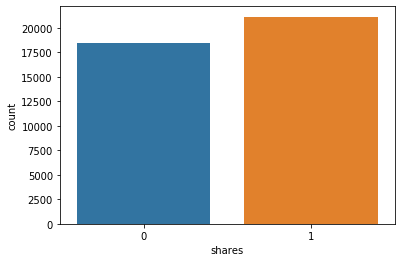

In [15]:
sns.countplot(x = 'shares', data=df)

In [16]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [17]:
X

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,title,content,label_by_mean,label_by_median,content_length
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.500000,-0.187500,0.000000,0.187500,0,Amazons Streaming Video Library Now a Little E...,Having trouble finding something to watch on A...,1,1,210
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,0,APs Twitter to Begin Displaying Sponsored Tweets,The Associated Press is the latest news organi...,1,1,250
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,1,Apples App Store Passes 40 Billion Downloads,It looks like 2012 was a pretty good year for ...,1,0,197
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,0,This Astronaut Is Rooting for Notre Dame Tonight,When it comes to college football NASA astrona...,1,1,478
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.454545,0.136364,0.045455,0.136364,0,New UVerse Apps Simplify Sharing Photos and Vi...,LAS VEGAS — Sharing photos and videos on your ...,1,1,289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,...,0.100000,0.000000,0.400000,0.000000,1,Samsung app aims to improve autistic childrens...,While some believe smartphones and tablets may...,1,0,285
39640,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,...,0.300000,1.000000,0.200000,1.000000,1,Seth Rogen James Franco are planning to livetw...,LOS ANGELES — Call it their exit Interview\n\n...,1,0,89
39641,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,1.0,...,0.454545,0.136364,0.045455,0.136364,1,App developer says Merry Christmas by paying o...,Nothing says Merry Christmas like never having...,1,0,100
39642,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,0,Two dead after Ukraine rocked by series of blasts,Ukrainians were on high alert on Saturday afte...,1,1,823


In [18]:
y


0        [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ...
1        [[12, 145, 146, 98, 12, 99, 147, 85, 6, 148, 9...
2        [[81, 263, 264, 265, 139, 100, 78, 237, 140, 6...
3        [[336, 81, 337, 6, 338, 339, 340, 341, 342, 34...
4        [[171, 172, 122, 525, 519, 25, 66, 8, 526, 26,...
                               ...                        
39639    [[235, 44, 3032, 538, 25, 585, 1030, 124, 2370...
39640    [[2453, 2454, 122, 3370, 81, 29, 21224, 380, 3...
39641    [[2369, 191, 7529, 1101, 264, 507, 2, 6, 1572,...
39642    [[75130, 571, 8, 1479, 4390, 8, 7069, 866, 100...
39643    [[216, 5600, 7, 134, 135, 122, 271, 430, 45, 9...
Name: encoded, Length: 39644, dtype: object

In [19]:
X = list(df['encoded'])
y = list(df['shares'])

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=69)

In [21]:
class NewsDataset(Dataset):
    def __init__(self, X, Y):
            self.X = X
            self.y = Y
            
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [22]:
train_ds = NewsDataset(X_train, y_train)
valid_ds = NewsDataset(X_valid, y_valid)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
def train_model(model):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
    actual_loss = None
    for i in range(EPOCHS):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in tqdm.tqdm(train_dl, total=len(train_dl)):
            x = x.long().to(device)
            y = y.long().to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() *y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if actual_loss is None or actual_loss >= val_loss:
            actual_loss = val_loss
#             print("Model Dict updated")
            torch.save(model.state_dict(),"./model.pt" )
            
        if i%5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in tqdm.tqdm(valid_dl, total=len(valid_dl)):
        x = x.long().to(device)
        y = y.long()
        y_hat = model(x, l).cpu()
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [25]:
vocab_size = len(words)
print(vocab_size)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)
np.save('vocab2index.npy',vocab2index)
np.save('wordlist.npy',words)

102824


In [26]:
x,y,l = train_ds[0]
len(train_dl), x.unsqueeze(0).shape

(208, torch.Size([1, 450]))

In [27]:
class LSTM_fixed_len(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [28]:
model_fixed = LSTM_fixed_len(vocab_size, 256, 256)
model_fixed

LSTM_fixed_len(
  (embeddings): Embedding(102824, 256, padding_idx=0)
  (lstm): LSTM(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [29]:
model_fixed.load_state_dict(torch.load("./model.pt"))
train_model(model_fixed.to(device))  

FileNotFoundError: [Errno 2] No such file or directory: './model.pt'

In [ ]:
## train data  
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 58.
        self.layer_1 = nn.Linear(58, NODES) 
        self.layer_2 = nn.Linear(NODES, NODES)
        self.layer_3 = nn.Linear(NODES, NODES)
        self.layer_4= nn.Linear(NODES, NODES)
        self.layer_out = nn.Linear(NODES, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(NODES)
        self.batchnorm2 = nn.BatchNorm1d(NODES)
        self.batchnorm3 = nn.BatchNorm1d(NODES)
        self.batchnorm4 = nn.BatchNorm1d(NODES)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)


In [ ]:
print(classification_report(y_test, y_pred_list))
